# Finetune an Automatic Speech Recognition (ASR) AI model

> Indented block

> Indented block

## 0. Setup

**Package Installations**

This code runs shell commands and install relevant python packages and libraries.

**GPU Configurations**

This code checks for GPU availability and prints their details. If a GPU is available, it compares the execution time of a matrix multiplication operation on both the CPU and GPU.

In [1]:
%%script echo
# %run misc.setup.py (COMMENT THIS LINE AFTER RUNNING THE CELL ONCE)
%run misc.gpu_config.py

#### Library Installations

In [2]:
%%script echo
%pip uninstall imageio -y
%pip install imageio
%pip uninstall pillow -y
%pip install --no-cache-dir pillow
%pip install datasets huggingface-hub librosa wordcloud
%pip install --upgrade evaluate jiwer
%pip install seaborn
%pip install transformers
%pip install tf-keras
%pip uninstall -y tensorflow tensorflow-macos tensorflow-metal keras
%pip install tensorflow==2.16.1 tensorflow-metal==1.1.0 keras==3.0.0 
%pip install pydub
# install ffmpeg: pydub relies on ffprobe to process audio files like MP3

#### Library Imports

In [3]:
import os                                        # Operating system-related functions (file, directory operations)
import sys                                       # Provides access to system-specific parameters and functions
import platform                                  # Provides functions and information about the operating system and hardware

import numpy as np                               # numerical operations & array manipulation
import pandas as pd
import pickle                                    # for object serialization & deserialization
import random                                    # generates random numbers
import math
import time

import matplotlib.pyplot as plt                  # Creating plots & visualizations
import seaborn as sns                            # Statistical data visualization library

# import cv2                                       # computer vision & image processing
import torch
import tensorflow as tf                          # deep learning framework
import keras                                     # training & evaluating deep learning models
import transformers
from tqdm import tqdm                            # creating progress bars in loops
from typing import Dict, List, Tuple, Optional   # type hinting
from IPython.display import display, HTML

# Audio / Speech Processing
import huggingface_hub
import librosa
import wordcloud
from wordcloud import WordCloud

In [4]:
# Add the current directory to the Python path
# sys.path.append(os.path.abspath('.'))

from misc.print_versions import print_system_and_package_info

libraries_to_check = [
    'conda', 'pip', '',
    # General Python Libraries
    'numpy', 'matplotlib', 'seaborn', 'tqdm', '',
    # Audio / Speech Processing
    'keras', 'tensorflow', 'transformers', 'huggingface_hub', 'librosa', 'wordcloud']

print_system_and_package_info(libraries_to_check, write_to_file=False)

System Information: 

Operating System: Darwin 24.2.0
No. of Processors: 8
Python Platform: macOS-15.2-arm64-arm-64bit
Python Version: 3.11.4 (v3.11.4:d2340ef257, Jun  6 2023, 19:15:51) [Clang 13.0.0 (clang-1300.0.29.30)]

Conda is not installed or not found in PATH.
Pip is not installed or not found in PATH.


Specified Packages:

Package             Version        Size (KB)      
--------------------------------------------------
conda               not installed  not installed  
pip                 24.3.1         18040.68       

numpy               1.26.3         58003.12       
matplotlib          3.9.1          27497.17       
seaborn             0.13.2         2256.83        
tqdm                4.67.1         383.89         

keras               3.0.0          8438.70        
tensorflow          2.16.1         1026593.50     
transformers        4.48.0         89558.98       
huggingface_hub     0.26.5         3594.54        
librosa             0.10.2.post1   4218.26        
w

## 1. Data Collection

For this project, we will be using the [Common Voice](https://www.kaggle.com/datasets/mozillaorg/common-voice/data) dataset sourced from Kaggle. The audio clips for each subset are stored as mp3 files in folders with the same naming conventions as their corresponding CSV files. For instance, all audio data from the valid train set is stored in the folder `cv-valid-train`, alongside the `cv-valid-train.csv` metadata file.

### **CSV File Structure**

Each row in the CSV file represents a single audio clip and contains the following information:

- **`filename`**: Relative path of the audio file.
- **`text`**: Supposed transcription of the audio.
- **`up_votes`**: Number of people who confirmed the audio matches the text.
- **`down_votes`**: Number of people who reported the audio does not match the text.
- **`age`**: Age of the speaker, if reported:
  - `teens`: `< 19`
  - `twenties`: `19 - 29`
  - `thirties`: `30 - 39`
  - `fourties`: `40 - 49`
  - `fifties`: `50 - 59`
  - `sixties`: `60 - 69`
  - `seventies`: `70 - 79`
  - `eighties`: `80 - 89`
  - `nineties`: `> 89`
- **`gender`**: Gender of the speaker, if reported:
  - `male`
  - `female`
  - `other`
- **`accent`**: Accent of the speaker, if reported:
  - `us`: `United States English`
  - `australia`: `Australian English`
  - `england`: `England English`
  - `canada`: `Canadian English`
  - `philippines`: `Filipino`
  - `hongkong`: `Hong Kong English`
  - `indian`: `India and South Asia (India, Pakistan, Sri Lanka)`
  - `ireland`: `Irish English`
  - `malaysia`: `Malaysian English`
  - `newzealand`: `New Zealand English`
  - `scotland`: `Scottish English`
  - `singapore`: `Singaporean English`
  - `southatlandtic`: `South Atlantic (Falkland Islands, Saint Helena)`
  - `african`: `Southern African (South Africa, Zimbabwe, Namibia)`
  - `wales`: `Welsh English`
  - `bermuda`: `West Indies and Bermuda (Bahamas, Bermuda, Jamaica, Trinidad)`

### **Acknowledgments**
This dataset was compiled by Michael Henretty, Tilman Kamp, Kelly Davis, and The Common Voice Team.

In [5]:
%%script echo
# Creating a grid for subplots with 2 columns
fig, axes = plt.subplots(3, 2, figsize=(12, 15), constrained_layout=True)

# 1. Up Votes vs. Down Votes
sns.scatterplot(data=df, x='up_votes', y='down_votes', alpha=0.6, ax=axes[0, 0])
axes[0, 0].set_title('Up Votes vs. Down Votes')
axes[0, 0].set_xlabel('Up Votes')
axes[0, 0].set_ylabel('Down Votes', rotation=0, labelpad=40)

# 2. Age Group Distribution
age_counts = df['age'].value_counts()
age_counts.plot(kind='bar', color='skyblue', ax=axes[0, 1])
axes[0, 1].set_title('Age Group Distribution')
axes[0, 1].set_xlabel('Age Group')
axes[0, 1].set_ylabel('Count', rotation=0, labelpad=40)
axes[0, 1].tick_params(axis='x', rotation=0)  # Ensure x-axis labels are horizontal

# 3. Gender Distribution
gender_counts = df['gender'].value_counts()
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[1, 0])
axes[1, 0].set_title('Gender Distribution')
axes[1, 0].set_ylabel('')  # Clear default ylabel

# 4. Accent Distribution
accent_counts = df['accent'].value_counts()
accent_counts.plot(kind='bar', color='coral', ax=axes[1, 1])
axes[1, 1].set_title('Accent Distribution')
axes[1, 1].set_xlabel('Accent')
axes[1, 1].set_ylabel('Count', rotation=0, labelpad=40)

# 5. Percentage of Missing Values per Column
missing_values = df.isnull().sum()
total_rows = len(df)
missing_percentage = (missing_values / total_rows) * 100
missing_percentage = missing_percentage[missing_percentage > 0]  # Filter columns with missing data
missing_percentage.sort_values().plot(kind='bar', color='orange', alpha=0.8, ax=axes[2, 1])
axes[2, 1].set_title('Percentage of Missing Values per Column')
axes[2, 1].set_xlabel('Column')
axes[2, 1].set_ylabel('Percentage', rotation=0, labelpad=40)
axes[2, 1].tick_params(axis='x', rotation=0)

plt.show()

## 2. Data Pre-processing

#### Data Cleaning
 * remove NaN or null values
 * remove irrelevant/ unnecessary data

#### Train-Validation Split

#### Preliminary Data Visualisation
* Waveform Visualization
* Mel-frequency cepstral coefficients (MFCCs) / Spectrogram


#### Data Extraction (Feature Engineering)


In [6]:
from sklearn.model_selection import train_test_split

# File paths
csv_file = '../common_voice/cv-valid-train.csv'
audio_dir = '../common_voice/cv-valid-train'

# Load the CSV file
df = pd.read_csv(csv_file)

# Display dataset overview
print('Dataset Overview:')
display(HTML(df.head().to_html()))

Dataset Overview:


,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the old king had said,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dreams said the old woman,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those omens that brought you to me,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me be the first to welcome you to earth,3,2,NaN,NaN,NaN,NaN


In [7]:
%%script echo
# Loading data online

from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()
common_voice['train'] = load_dataset('mozilla-foundation/common_voice_11_0', 'en', split='train+validation')
# common_voice['test'] = load_dataset('mozilla-foundation/common_voice_13_0', 'en', split='test')
# DatasetNotFoundError: Dataset 'mozilla-foundation/common_voice_13_0' is a gated dataset on the Hub. You must be authenticated to access it.

# Perform a custom split (70% train, 30% validation)
split_datasets = dataset.train_test_split(test_size=0.3, seed=0)
train_dataset  = split_datasets['train']
val_dataset    = split_datasets['test']
print(f'Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}')
print(common_voice)

Number of data in csv: 195776
Number of data in training: 137043
Number of data in validation: 58733

Preprocessing audio files...
Error processing ../common_voice/cv-valid-train/cv-valid-train/sample-031723.mp3: strip_silence() got an unexpected keyword argument 'silence_threshold'
Error processing ../common_voice/cv-valid-train/cv-valid-train/sample-165673.mp3: strip_silence() got an unexpected keyword argument 'silence_threshold'
Error processing ../common_voice/cv-valid-train/cv-valid-train/sample-113067.mp3: strip_silence() got an unexpected keyword argument 'silence_threshold'

Processed DataFrame with features:


,filename,text,up_votes,down_votes,age,gender,accent,duration,processed_path,duration,mfccs,energy,zero_crossing_rate
0,cv-valid-train/sample-031723.mp3,he could always become a crystal salesman again,1,0,NaN,NaN,NaN,NaN,../common_voice/cv-valid-train/cv-valid-train/...,3.648,"[-275.44034, 86.45225, 2.6289947, 12.932542, 1...",78.689934,0.113413
1,cv-valid-train/sample-165673.mp3,the old man looked disappointed,3,0,NaN,NaN,NaN,NaN,../common_voice/cv-valid-train/cv-valid-train/...,3.888,"[-353.50366, 74.54851, 4.7647076, -0.57392615,...",818.984863,0.116935
2,cv-valid-train/sample-113067.mp3,but now i'm sad and alone,1,0,thirties,male,england,NaN,../common_voice/cv-valid-train/cv-valid-train/...,2.256,"[-406.53168, 81.16569, -7.1284666, 19.765247, ...",55.015179,0.125186



Playing audio samples:

Playing ../common_voice/cv-valid-train/cv-valid-train/sample-031723.mp3



Playing ../common_voice/cv-valid-train/cv-valid-train/sample-165673.mp3



Playing ../common_voice/cv-valid-train/cv-valid-train/sample-113067.mp3



Visualizing audio features for the selected files...


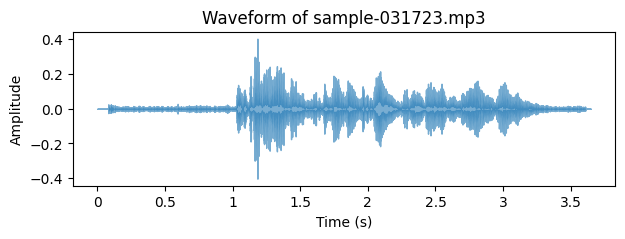

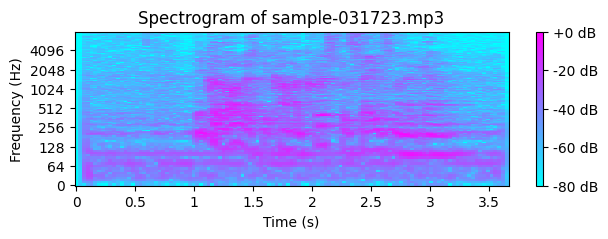

In [8]:
from IPython.display import Audio, display
from data_cleaning import preprocess_data, visualize_audio_features

# Training-Validation Split: 70-30
train_df, val_df = train_test_split(df, test_size=0.3, random_state=123)

# Save the splits if needed
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)

# Display number of samples in each split
print(f'Number of data in csv: {len(df)}')
print(f'Number of data in training: {len(train_df)}')
print(f'Number of data in validation: {len(val_df)}')

# Randomly select x files for testing
x = 3
df_sample = train_df.sample(x, random_state=0).reset_index(drop=True)

# Preprocess audio files
print('\nPreprocessing audio files...')
processed_df = preprocess_data(df_sample, audio_dir)

# Display the resulting DataFrame
print('\nProcessed DataFrame with features:')
display(processed_df)

# Play the first processed audio file
print('\nPlaying audio samples:')
for idx, row in processed_df.iterrows():
    if 'processed_path' in row and pd.notnull(row['processed_path']):
        print(f"\nPlaying {row['processed_path']}")
        display(Audio(filename=row['processed_path']))
        if idx >= x:  # Limit playback to x files
            break

# Visualize features for the processed audio files
print('\nVisualizing audio features for the selected files...')
visualize_audio_features(processed_df, audio_dir, sample_num=1)

## 2. Data Extraction (Feature Engineering)

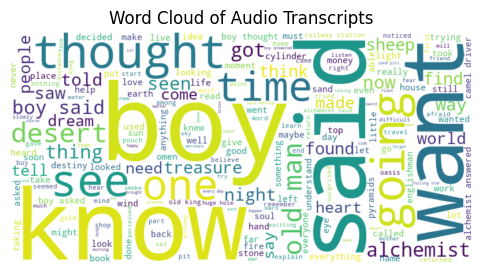

In [9]:
# Word Cloud
text_data = ' '.join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(8, 3))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Audio Transcripts')
plt.show()

In [10]:
%run misc/evaluation_metrics.py

Orthographic WER: 33.33%
Normalized WER: 33.33%


## 5. Model Choice

The chosen ASR AI Model is [wav2vec2-large-960h](https://huggingface.co/facebook/wav2vec2-large-960h). This model is developed by Facebook and pretrained and fine-tuned on Librispeech dataset on 16kHz sampled speech audio.


In [11]:
# # Use a pipeline as a high-level helper
# from transformers import pipeline
# pipe = pipeline('automatic-speech-recognition', model='facebook/wav2vec2-large-960h')

from transformers import AutoProcessor, AutoModelForCTC
# # Load processor and model directly using downloaded paths
# processor = AutoProcessor.from_pretrained('facebook/wav2vec2-large-960h')
# model = AutoModelForCTC.from_pretrained('facebook/wav2vec2-large-960h')
# model_dir = 'model'
# processor.save_pretrained(model_dir)
# model.save_pretrained(model_dir)

# Load processor and model from the saved directory
model_dir = 'model'
processor = AutoProcessor.from_pretrained(model_dir)
model = AutoModelForCTC.from_pretrained(model_dir)

# Verify that the model and processor are loaded
print('Processor and model successfully loaded from the folder:', model_dir)

Processor and model successfully loaded from the folder: model


In [12]:
%%script echo
from transformers import WhisperForConditionalGeneration
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

## 6. Model Training

In [13]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Processor
from pydub import AudioSegment

# Feature extraction for raw audio
audio_dir: str = '../common_voice/cv-valid-train/cv-valid-train/sample-031723.mp3'
audio: AudioSegment = AudioSegment.from_file(audio_dir)

# Convert audio to numpy array (normalized to [-1, 1])
samples: np.ndarray = np.array(audio.get_array_of_samples(), dtype=np.float32)
samples = samples / np.iinfo(audio.array_type).max  # Normalize to range [-1, 1]

# Load Wav2Vec2Processor (handles both feature extraction and tokenization)
processor: Wav2Vec2Processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-large-960h')

# Extract features for the model
input_values: torch.Tensor = processor.feature_extractor(samples, sampling_rate=16000, return_tensors='pt').input_values

# Tokenizing text transcriptions correctly
labels: torch.Tensor = processor.tokenizer('this is a sample transcription', return_tensors='pt').input_ids

# Debug: Print types to trace input and output
print(f'Audio Type: {type(audio)}')                                             # <class 'pydub.audio_segment.AudioSegment'>
print(f'Samples Type: {type(samples)}, Shape: {samples.shape}')                 # <class 'numpy.ndarray'>
print(f'Input Values Type: {type(input_values)}, Shape: {input_values.shape}')  # <class 'torch.Tensor'>
print(f'Labels Type: {type(labels)}, Shape: {labels.shape}')                    # <class 'torch.Tensor'>

Audio Type: <class 'pydub.audio_segment.AudioSegment'>
Samples Type: <class 'numpy.ndarray'>, Shape: (175104,)
Input Values Type: <class 'torch.Tensor'>, Shape: torch.Size([1, 175104])
Labels Type: <class 'torch.Tensor'>, Shape: torch.Size([1, 30])


In [ ]:
from datasets import Dataset
import pandas as pd

train_df, val_df = train_test_split(df, test_size=0.3, random_state=123)

# Keep only required columns
train_df = train_df[['filename', 'text']].rename(columns={'filename': 'path'})
eval_df = val_df[['filename', 'text']].rename(columns={'filename': 'path'})


# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset  = Dataset.from_pandas(eval_df)

# Apply preprocessing function
# from data_cleaning import preprocess_audio

def preprocess_audio(example):
    '''Loads an audio file and extracts features for Wav2Vec2'''
    file_path = str('../common_voice/cv-valid-train/' + example['path'])  # Ensure it's a string

    try:
        # Load the audio file using librosa
        speech_array, sampling_rate = librosa.load(file_path, sr=16000)
        example['input_values'] = processor(speech_array, sampling_rate=16000).input_values[0]
        example['labels'] = processor.tokenizer(example['text']).input_ids  # Convert text to tokenized labels
    except Exception as e:
        print(f'Error loading {file_path}: {e}')
        example['input_values'] = None  # Handle missing files gracefully
        example['labels'] = None

    return example

train_dataset = train_dataset.map(preprocess_audio, remove_columns=['path', 'text'])
eval_dataset = eval_dataset.map(preprocess_audio, remove_columns=['path', 'text'])


# Ensure unnecessary columns (like DataFrame index) are removed
if '__index_level_0__' in train_dataset.column_names:
    train_dataset = train_dataset.remove_columns(['__index_level_0__'])
    eval_dataset  = eval_dataset.remove_columns(['__index_level_0__'])

print(train_dataset)
print(eval_dataset)

Map:   0%|          | 0/137043 [00:00<?, ? examples/s]

In [33]:
# Force PyTorch to use CPU
device = torch.device('cpu')
torch.set_default_device(device)  # Ensures all new tensors are on CPU

from transformers import Wav2Vec2ForCTC, Trainer, TrainingArguments

# Load model
model = Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-large-960h',
    ctc_loss_reduction='mean',
    pad_token_id=processor.tokenizer.pad_token_id,
)
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h", vocab_size=len(tokenizer))
    
# Define training arguments
training_args = TrainingArguments(
    output_dir='./wav2vec2-finetuned',
    evaluation_strategy='epoch',
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    save_steps=500,
    logging_steps=100,
    save_total_limit=2,
    fp16=False,
    no_cuda=True,
    remove_unused_columns=False
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
    # tokenizer=tokenizer,
)

# Start training
trainer.train()

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:1590: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/var/folders/br/czgt0zz514dfx5f0w14p4czr0000gn/T/ipykernel_93326/3539321290.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing

ValueError: You should supply an instance of `transformers.BatchFeature` or list of `transformers.BatchFeature` to this method that includes input_values, but you provided ['path', 'text']

## 7. Model Evaluation

For evaluating models like `Wav2Vec2ForCTC` in tasks such as Automatic Speech Recognition (ASR), the following metrics are typically used:

### 1. Word Error Rate (WER)
- **Definition**: Measures the percentage of incorrectly predicted words in the transcript.
- **Formula**:
  $WER = \frac{S + D + I}{N}$
  where:
  - \( S \): Number of substitutions (wrong word predicted).
  - \( D \): Number of deletions (missing words in prediction).
  - \( I \): Number of insertions (extra words in prediction).
  - \( N \): Total number of words in the reference transcript.
- **Usage**:
  - Lower WER indicates better model performance.
  - It is the most common metric for ASR systems.

---

## 8. Model Understanding (Explainability)

The implementation from sklearn will serve as a benchmark for us to determine how good the current implementation of decision tree model and the k nearest neighbours classifier is.


## 9. Model Deployment

